In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
import argparse

import numpy as np
import torch
from PIL import Image

from model.VRP_encoder import VRP_encoder
from SAM2pred import SAM_pred

/home/adam/.pyenv/versions/3.10.16/envs/vrp_sam/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
DEVICE = 'cuda'

In [4]:
sam_model = SAM_pred()
sam_model.to(DEVICE);


In [5]:
arg_dict = {
    "datapath": "/home/adam/Development/external/Datasets_HSN",
    "benchmark": "coco",                     
    "logpath": "trn1_coco_mask_fold0",
    "bsz": 2,
    "lr": 0.0001,
    "weight_decay": 1e-06,
    "epochs": 50,            
    "nworker": 8,                      
    "seed": 321,                   
    "fold": 0,                    
    "condition": "mask",
    "use_ignore": True,
    "local_rank": 0,
    "num_query": 50,
    "backbone": "resnet50",
}
args = argparse.Namespace(**arg_dict)

model = VRP_encoder(args, 'resnet50', False)
model.load_state_dict(torch.load("/home/adam/Development/external/VRP-SAM/logs/trn2_coco_mask_fold0.log/best_model.pt"))
model.to(DEVICE);


In [6]:
from torchvision import transforms
from data.coco import DatasetCOCO

transform = transforms.Compose(
    [
        transforms.Resize(size=(512, 512)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

dataset = DatasetCOCO(
    "/home/adam/Development/external/Datasets_HSN/",
    fold=0,
    transform=transform,
    split="train2014",
    shot=1,
    use_original_imgsize=False
)

Total (trn) images are : 21917


In [7]:
# batch = next(iter(loader))
# batch = dataset[1]

In [57]:
support_path = "/home/adam/Development/external/VRP-SAM/test_data/P4 RTK Surveying.jpg"
support_img = Image.open(support_path)
support_img = transform(support_img)

support_mask = np.load("/home/adam/Development/external/VRP-SAM/test_data/task-3-annotation-2-by-1-tag-Drone-0.npy")
support_mask = torch.as_tensor(support_mask).unsqueeze(0)
support_mask = transforms.functional.resize(support_mask, size=(512,512))

# query_path = "/home/adam/Development/external/VRP-SAM/test_data/fixed_wing.jpg"
query_path = "/home/adam/Development/external/VRP-SAM/test_data/many_drones.jpg"
# query_path = "/home/adam/Development/external/VRP-SAM/test_data/delivery-drone.jpg"
query_img = Image.open(query_path)
query_img = transform(query_img)


In [58]:
batch = {
    "query_img": query_img,
    "support_imgs": support_img.unsqueeze(0),
    "support_masks": support_mask,
    "query_name": "Daryl"
}

In [59]:
def int_scale(image: np.ndarray) -> np.ndarray:
    return 255* (image - image.min()) / (image.max() - image.min())

In [60]:
protos, _ = model(
    "mask",
    batch["query_img"].to(DEVICE).unsqueeze(0),
    batch["support_imgs"].squeeze(1).to(DEVICE),
    batch["support_masks"].squeeze(1).to(DEVICE),
    False,
)

In [61]:
logit_mask, _ = sam_model(batch["query_img"].to(DEVICE).unsqueeze(0), [batch["query_name"]], protos)
pred_mask = torch.sigmoid(logit_mask) > 0.5
pred_mask = pred_mask.float()

In [62]:
import matplotlib.pyplot as plt
import numpy as np

support_img = batch["support_imgs"].squeeze().transpose(0, 1).transpose(1, 2).numpy()
support_img = (support_img - support_img.min(axis=(0, 1), keepdims=True)) / (support_img.max(axis=(0, 1), keepdims=True) - support_img.min(axis=(0, 1), keepdims=True)) 
support_img = (255 * support_img).astype(np.uint8)
support_mask = batch["support_masks"]

query_img = batch["query_img"].transpose(0, 1).transpose(1, 2).numpy()
query_img = (query_img - query_img.min(axis=(0, 1), keepdims=True)) / (query_img.max(axis=(0, 1), keepdims=True) - query_img.min(axis=(0, 1), keepdims=True)) 
query_img = (255 * query_img).astype(np.uint8)
query_mask = pred_mask.detach().cpu().squeeze(0)

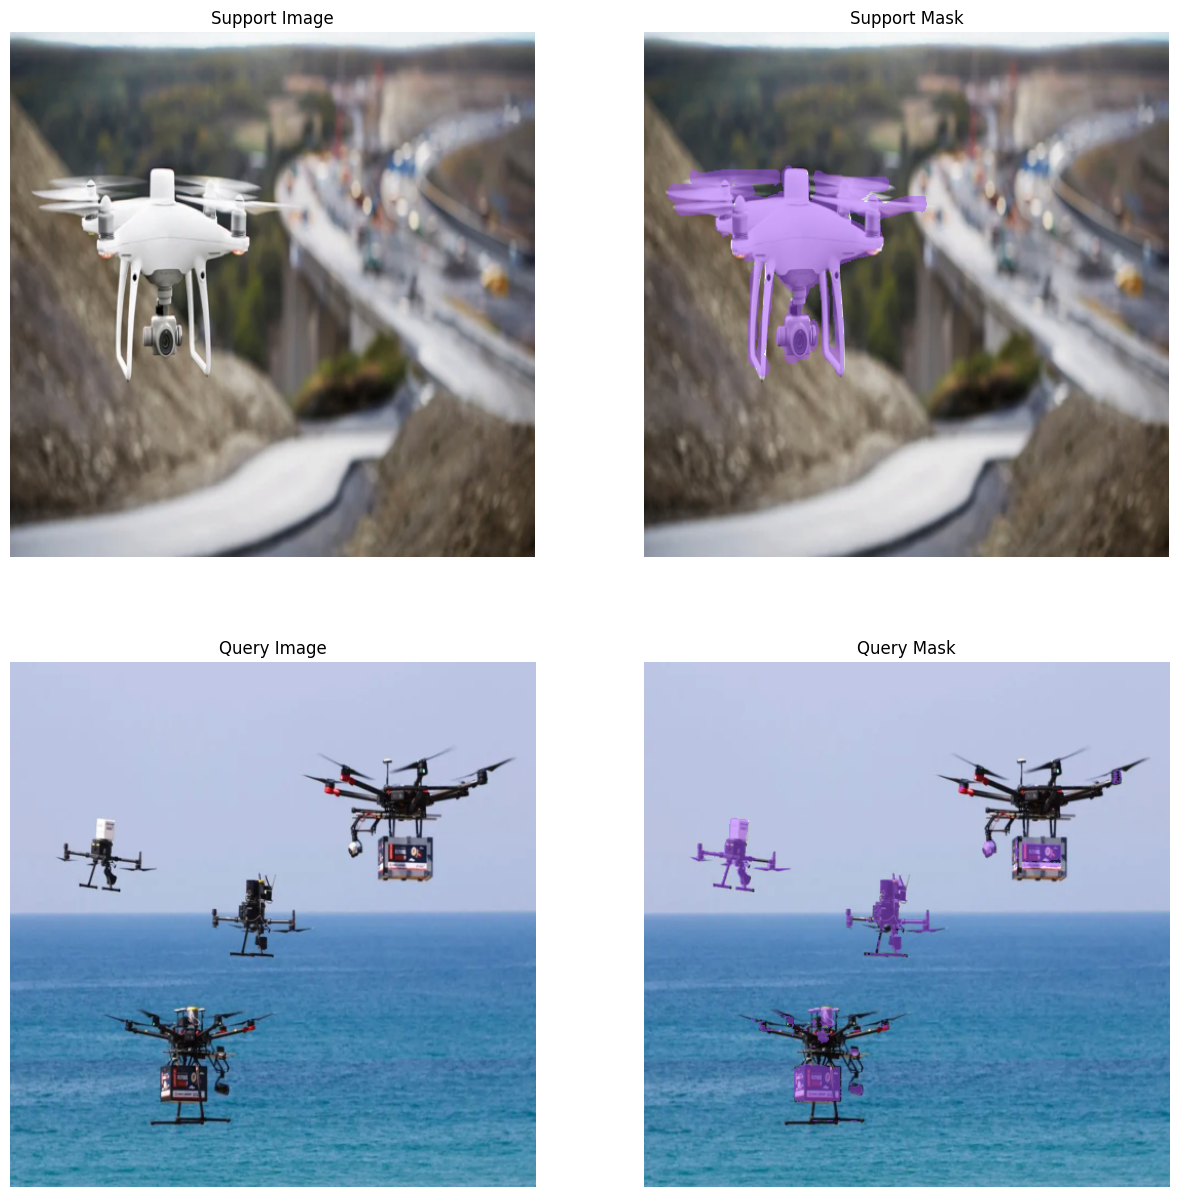

In [63]:
import supervision as sv

mask_annotator = sv.MaskAnnotator()
support_detections = sv.Detections(xyxy=sv.mask_to_xyxy(masks=support_mask), mask=support_mask.bool().numpy(), class_id=np.array([0]))
query_detections = sv.Detections(xyxy=sv.mask_to_xyxy(masks=query_mask), mask=query_mask.bool().numpy(), class_id=np.array([0]))

support_img = np.flip(support_img, axis=-1)
query_img = np.flip(query_img, axis=-1)
annotated_support = mask_annotator.annotate(support_img, detections=support_detections)
annotated_query = mask_annotator.annotate(query_img, detections=query_detections)

sv.plot_images_grid([support_img, annotated_support, query_img, annotated_query], grid_size=(2,2), titles=["Support Image", "Support Mask", "Query Image", "Query Mask"], size=(15,15))
# sv.plot_images_grid([annotated_support, annotated_query], grid_size=(1,2), titles=["Support Image", "Query Image"], size=(22,22))

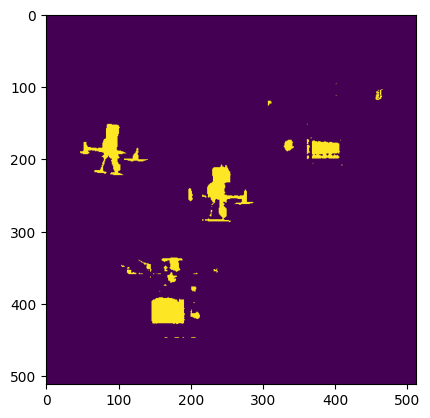

In [64]:
plt.imshow(query_mask.squeeze(0).bool().numpy())